# Pregunta 1:

Se describe el tutorial y se realiza paso por paso:

- ¿Que es una Kolmogorov-Arnold Network (KAN)?

Primero se describe lo que es una KAN, lo que corresponde a una arquitectura de red neuronal la que se inspira en el Teorema de Representación de Kolmogorov-Arnold. Este teorema indica que cualquier función multivariable continua se puede representar como una suma finita de funciones continuas de una sola variable. Esto permite que KAN pueda descomponer una función compleja en la suma de varias funciones más simples.

- Conceptos:

1. Edge functions (ϕ):
Corresponde a las funciones que aplican una transformación no lineal a las entradas. Para estas, se van a implementar utilizando funciones B-spline, que corresponden a polinomios para presentar datos no lineales.

2. Node functions (g):
Corresponde a las funciones que aplican una transformación no lineal a las salidas de las edge functions. Para estas, se van a implementar utilizando funciones B-spline, que corresponda polinomios para presentar datos no lineales.

## 1 - Primero se implementa una arquitectura neuronal versátil.

Primero se implementa una arquitectura neuronal general, que se pueda utilizar tanto en las KAN como en una MLP.



In [ ]:
import numpy as np

class Neuron:

    def __init__(self, n_in, n_weights_per_edge, weights_range=None):
        self.n_in = n_in  # n. inputs
        self.n_weights_per_edge = n_weights_per_edge
        weights_range = [-1, 1] if weights_range is None else weights_range
        self.weights = np.random.uniform(weights_range[0], weights_range[-1], size=(self.n_in, self.n_weights_per_edge))
        self.bias = 0
        self.xin = None  # input variable
        self.xmid = None  # edge variables
        self.xout = None  # output variable
        self.dxout_dxmid = None  # derivative d xout / d xmid: (n_in, )
        self.dxout_dbias = None  # derivative d xout / d bias
        self.dxmid_dw = None  # derivative d xmid / d w: (n_in, n_par_per_edge)
        self.dxmid_dxin = None  # derivative d xmid / d xin
        self.dxout_dxin = None  # (composite) derivative d xout / d xin
        self.dxout_dw = None  # (composite) derivative d xout / d w
        self.dloss_dw = np.zeros((self.n_in, self.n_weights_per_edge))  # (composite) derivative d loss / d w
        self.dloss_dbias = 0  # (composite) derivative d loss / d bias

    def __call__(self, xin):
        # forward pass: compute neuron's output
        self.xin = np.array(xin)
        self.get_xmid()
        self.get_xout()

        # compute internal derivatives
        self.get_dxout_dxmid()
        self.get_dxout_dbias()
        self.get_dxmid_dw()
        self.get_dxmid_dxin()

        assert self.dxout_dxmid.shape == (self.n_in, )
        assert self.dxmid_dxin.shape == (self.n_in, )
        assert self.dxmid_dw.shape == (self.n_in, self.n_weights_per_edge)

        # compute external derivatives
        self.get_dxout_dxin()
        self.get_dxout_dw()

        return self.xout

    def get_xmid(self):
        # compute self.xmid
        pass

    def get_xout(self):
        # compute self.xout
        pass

    def get_dxout_dxmid(self):
        # compute self.dxout_dxmid
        pass

    def get_dxout_dbias(self):
        # compute self.dxout_dbias
        pass  #self.dxout_dbias = 0  # by default

    def get_dxmid_dw(self):
        # compute self.dxmid_dw
        pass

    def get_dxmid_dxin(self):
        # compute self.dxmid_dxin
        pass

    def get_dxout_dxin(self):
        self.dxout_dxin = self.dxout_dxmid * self.dxmid_dxin

    def get_dxout_dw(self):
        self.dxout_dw = np.diag(self.dxout_dxmid) @ self.dxmid_dw

    def update_dloss_dw_dbias(self, dloss_dxout):
        self.dloss_dw += self.dxout_dw * dloss_dxout
        self.dloss_dbias += self.dxout_dbias * dloss_dxout

    def gradient_descent(self, eps):
        self.weights -= eps * self.dloss_dw
        self.bias -= eps * self.dloss_dbias

Como se puede observar en el código, en este se implementa una neurona personalizada, donde se realizan los calculos explicitos del proceso neuronal llamado propagación hacia adelante. Luego se aplica el ajuste y configuración de los pesos con backpropagation y la optimización, usando decenso por gradiente.

Primero, se realiza la entrada de la clase con el conjunto X_in, donde se definen los atributos principales de la clase (en el constructor __init__). En este se definen los atributos principales:

- n_in: Número de entradas a la neurona.
- n_weights_per_edge: Número de pesos por conexión de entrada,donde se hace una representación más compleja que una neurona estándar.
- weights: Es la matriz de pesos inicializada aleatoriamente. Esto para la union de cada perceptrón.
- bias: donde se define el sesgo inicial de la neurona, que será igual a 0.
- xin, xmid, xout: Variables que representan las entradas, salidas intermedias y la salida final de la neurona.
- dloss_dw y dloss_dbias: Gradientes acumulados de la función de pérdida, con respecto a los pesos y el sesgo.

Luego de esto, se realiza la propagación hacia adelante, con el metodo __call__. En este se ejecuta con el parametro del conjunto de entradas. Donde se realizan los cálculos intermedios, donde se consideran los pesos y las funciones gradientes. En las derivadas internas, se calculan para posteriormente realizar el Backpropagation.

En el método "update_dloss_dw_dbias(self, dloss_dxout)", se calcula la actualización del gradiente, donde se utiliza la derivada de la pérdida, con respecto a la salida de la neurona.

Finalmente, en la función "gradient_descent(self, eps)", se realiza la actualización de los pesos y el sesgo usando el descenso por gradiente. Cabe destacar el el parámetro "eps", corresponde a la tasa de aprendizaje.


A continuación se muestra como se implementan las funciones de activación, RELU, Tangente hiperbolica y la función sigmoide. De esta manera, se puede instanciar la estructura general de una neurona "clásica".

In [ ]:
import math

def relu(x, get_derivative=False):
    return x * (x > 0) if not get_derivative else 1.0 * (x >= 0)

def tanh_act(x, get_derivative=False):
    if not get_derivative:
        return math.tanh(x)
    return 1 - math.tanh(x) ** 2

def sigmoid_act(x, get_derivative=False):
    if not get_derivative:
        return 1 / (1 + math.exp(-x))
    return sigmoid_act(x) * (1 - sigmoid_act(x))

Luego se crea la clase NeuronNN(Neuron), la cual se hereda de la clase Nueron mostrada anteriormente. Aquí se calculan las derivadas auxiliares que se necesitan para poder producir el gradiente de pérdida. Este gradiente de perdida, se encarga de evaluar la calidad de la prediccón de la red, haciendo una comparación de los resultados obtenidos con los datos reales.

$\displaystyle \frac{\mathrm{d} x^{\mathrm{mid}}_i}{\mathrm{d} w^i} = x_i^{\mathrm{in}}, \quad \frac{\mathrm{ d} x^{\mathrm{mid}}_i}{x_i^{\mathrm{in}}} = \mathrm{d} w^i, \quad \frac{\mathrm{d} x^{\mathrm{out}}}{\mathrm{d} x^{\mathrm{mid}}_i} = \frac{\mathrm{d} x^{\mathrm{ out}}}{\mathrm{d} b} = \sigma'. \ \ \ \ \ $

La idea de utilizar este gradiente de pérdida, es poder adaptar los sesgos y los pesos de la red neuronal, y así poder minimizar la pérdida. Para esto, se muestra el código completamente de la implementación de una neurona simple, donde NuronNN(Neuron), proporciona una implementación funcional que permite realizar la propagación hacia adelante, permitiendo el aprendizaje con lo mencionado anteriormente.

In [ ]:
import numpy as np
import math


class Neuron:

    def __init__(self, n_in, n_weights_per_edge, weights_range=None):
        self.n_in = n_in  # n. inputs
        self.n_weights_per_edge = n_weights_per_edge
        weights_range = [-1, 1] if weights_range is None else weights_range
        self.weights = np.random.uniform(weights_range[0], weights_range[-1], size=(self.n_in, self.n_weights_per_edge))
        self.bias = 0
        self.xin = None  # input variable
        self.xmid = None  # edge variables
        self.xout = None  # output variable
        self.dxout_dxmid = None  # derivative d xout / d xmid: (n_in, )
        self.dxout_dbias = None  # derivative d xout / d bias
        self.dxmid_dw = None  # derivative d xmid / d w: (n_in, n_par_per_edge)
        self.dxmid_dxin = None  # derivative d xmid / d xin
        self.dxout_dxin = None  # (composite) derivative d xout / d xin
        self.dxout_dw = None  # (composite) derivative d xout / d w
        self.dloss_dw = np.zeros((self.n_in, self.n_weights_per_edge))  # (composite) derivative d loss / d w
        self.dloss_dbias = 0  # (composite) derivative d loss / d bias

    def __call__(self, xin):
        # forward pass: compute neuron's output
        self.xin = np.array(xin)
        self.get_xmid()
        self.get_xout()

        # compute internal derivatives
        self.get_dxout_dxmid()
        self.get_dxout_dbias()
        self.get_dxmid_dw()
        self.get_dxmid_dxin()

        assert self.dxout_dxmid.shape == (self.n_in, )
        assert self.dxmid_dxin.shape == (self.n_in, )
        assert self.dxmid_dw.shape == (self.n_in, self.n_weights_per_edge)

        # compute external derivatives
        self.get_dxout_dxin()
        self.get_dxout_dw()

        return self.xout

    def get_xmid(self):
        # compute self.xmid
        pass

    def get_xout(self):
        # compute self.xout
        pass

    def get_dxout_dxmid(self):
        # compute self.dxout_dxmid
        pass

    def get_dxout_dbias(self):
        # compute self.dxout_dbias
        pass  #self.dxout_dbias = 0  # by default

    def get_dxmid_dw(self):
        # compute self.dxmid_dw
        pass

    def get_dxmid_dxin(self):
        # compute self.dxmid_dxin
        pass

    def get_dxout_dxin(self):
        self.dxout_dxin = self.dxout_dxmid * self.dxmid_dxin

    def get_dxout_dw(self):
        self.dxout_dw = np.diag(self.dxout_dxmid) @ self.dxmid_dw

    def update_dloss_dw_dbias(self, dloss_dxout):
        self.dloss_dw += self.dxout_dw * dloss_dxout
        self.dloss_dbias += self.dxout_dbias * dloss_dxout

    def gradient_descent(self, eps):
        self.weights -= eps * self.dloss_dw
        self.bias -= eps * self.dloss_dbias


def relu(x, get_derivative=False):
    return x * (x > 0) if not get_derivative else 1.0 * (x >= 0)

def tanh_act(x, get_derivative=False):
    if not get_derivative:
        return math.tanh(x)
    return 1 - math.tanh(x) ** 2

def sigmoid_act(x, get_derivative=False):
    if not get_derivative:
        return 1 / (1 + math.exp(-x))
    return sigmoid_act(x) * (1 - sigmoid_act(x))


class NeuronNN(Neuron):

    def __init__(self, n_in, weights_range=None, activation=relu):
        super().__init__(n_in, n_weights_per_edge=1, weights_range=weights_range)
        self.activation = activation
        self.activation_input = None

    def get_xmid(self):
        self.xmid = self.weights[:, 0] * self.xin

    def get_xout(self):
        self.activation_input = sum(self.xmid.flatten()) + self.bias
        self.xout = self.activation(self.activation_input, get_derivative=False)

    def get_dxout_dxmid(self):
        self.dxout_dxmid = self.activation(self.activation_input, get_derivative=True) * np.ones(self.n_in)

    def get_dxout_dbias(self):
        self.dxout_dbias = self.activation(self.activation_input, get_derivative=True)

    def get_dxmid_dw(self):
        self.dxmid_dw = np.reshape(self.xin, (-1, 1))

    def get_dxmid_dxin(self):
        self.dxmid_dxin = self.weights.flatten()

Luego de haber implementado la red de una neurona clasica, se procede a mostrar el uso de una neurona Kolmogorov-Arnold Network (KAN). Este algoritmo, utiliza la función de borde Φ, que se define como la combinación lineal de funciones no lineales, simplificando la ecuación. Las funciones del sistema deben ser B-spline, la que se aplica de la siguiente forma:

$\displaystyle x^{\mathrm{mid}}_i = \phi\left(x^{\mathrm{in}}_i \right) := \sum_{k=1}^K w^i_k f_k \left(x^{\mathrm{in}}_i\right) \ \ \ \ \ $

In [ ]:
from scipy.interpolate import BSpline

def get_bsplines(x_bounds, n_fun, degree=3, **kwargs):
    grid_len = n_fun - degree + 1
    step = (x_bounds[1] - x_bounds[0]) / (grid_len - 1)
    edge_fun, edge_fun_der = {}, {}

    # SiLU bias function
    edge_fun[0] = lambda x: x / (1 + np.exp(-x))
    edge_fun_der[0] = lambda x: (1 + np.exp(-x) + x * np.exp(-x)) / np.power((1 + np.exp(-x)), 2)

    # B-splines
    t = np.linspace(x_bounds[0] - degree * step, x_bounds[1] + degree * step, grid_len + 2 * degree)
    t[degree], t[-degree - 1] = x_bounds[0], x_bounds[1]
    for ind_spline in range(n_fun - 1):
        edge_fun[ind_spline + 1] = BSpline.basis_element(t[ind_spline:ind_spline + degree + 2], extrapolate=False)
        edge_fun_der[ind_spline + 1] = edge_fun[ind_spline + 1].derivative()
    return edge_fun, edge_fun_der

De esta manera se representa la función nodo para la red KAN, donde se puede expresar como la suma de las variables intermedias. En este tutorial, para simplificar  y evitar actualizar las cuadriculas spline, se utiliza ${\sigma:=\mathrm{tanh}}$ para poder obtener que la salida varíe entre -1 y 1.

El siguiente código se implementa la neurona KAN, donde en la clase NeuronKAN, se utiliza la clase Neuron para poder calcular las salidas intermedias y la salida de la función de activación, que como se menciona anteriormente, se utiliza tanh. Así se deriva casa salida B-spline con el metodo .derivate(), para poder realizar el aprendizaje a través de Backpropagation.

In [ ]:
import numpy as np
import math
from scipy.interpolate import BSpline


class Neuron:

    def __init__(self, n_in, n_weights_per_edge, weights_range=None):
        self.n_in = n_in  # n. inputs
        self.n_weights_per_edge = n_weights_per_edge
        weights_range = [-1, 1] if weights_range is None else weights_range
        self.weights = np.random.uniform(weights_range[0], weights_range[-1], size=(self.n_in, self.n_weights_per_edge))
        self.bias = 0
        self.xin = None  # input variable
        self.xmid = None  # edge variables
        self.xout = None  # output variable
        self.dxout_dxmid = None  # derivative d xout / d xmid: (n_in, )
        self.dxout_dbias = None  # derivative d xout / d bias
        self.dxmid_dw = None  # derivative d xmid / d w: (n_in, n_par_per_edge)
        self.dxmid_dxin = None  # derivative d xmid / d xin
        self.dxout_dxin = None  # (composite) derivative d xout / d xin
        self.dxout_dw = None  # (composite) derivative d xout / d w
        self.dloss_dw = np.zeros((self.n_in, self.n_weights_per_edge))  # (composite) derivative d loss / d w
        self.dloss_dbias = 0  # (composite) derivative d loss / d bias

    def __call__(self, xin):
        # forward pass: compute neuron's output
        self.xin = np.array(xin)
        self.get_xmid()
        self.get_xout()

        # compute internal derivatives
        self.get_dxout_dxmid()
        self.get_dxout_dbias()
        self.get_dxmid_dw()
        self.get_dxmid_dxin()

        assert self.dxout_dxmid.shape == (self.n_in, )
        assert self.dxmid_dxin.shape == (self.n_in, )
        assert self.dxmid_dw.shape == (self.n_in, self.n_weights_per_edge)

        # compute external derivatives
        self.get_dxout_dxin()
        self.get_dxout_dw()

        return self.xout

    def get_xmid(self):
        # compute self.xmid
        pass

    def get_xout(self):
        # compute self.xout
        pass

    def get_dxout_dxmid(self):
        # compute self.dxout_dxmid
        pass

    def get_dxout_dbias(self):
        # compute self.dxout_dbias
        pass  #self.dxout_dbias = 0  # by default

    def get_dxmid_dw(self):
        # compute self.dxmid_dw
        pass

    def get_dxmid_dxin(self):
        # compute self.dxmid_dxin
        pass

    def get_dxout_dxin(self):
        self.dxout_dxin = self.dxout_dxmid * self.dxmid_dxin

    def get_dxout_dw(self):
        self.dxout_dw = np.diag(self.dxout_dxmid) @ self.dxmid_dw

    def update_dloss_dw_dbias(self, dloss_dxout):
        self.dloss_dw += self.dxout_dw * dloss_dxout
        self.dloss_dbias += self.dxout_dbias * dloss_dxout

    def gradient_descent(self, eps):
        self.weights -= eps * self.dloss_dw
        self.bias -= eps * self.dloss_dbias


def get_bsplines(x_bounds, n_fun, degree=3, **kwargs):
    grid_len = n_fun - degree + 1
    step = (x_bounds[1] - x_bounds[0]) / (grid_len - 1)
    edge_fun, edge_fun_der = {}, {}

    # SiLU bias function
    edge_fun[0] = lambda x: x / (1 + np.exp(-x))
    edge_fun_der[0] = lambda x: (1 + np.exp(-x) + x * np.exp(-x)) / np.power((1 + np.exp(-x)), 2)

    # B-splines
    t = np.linspace(x_bounds[0] - degree * step, x_bounds[1] + degree * step, grid_len + 2 * degree)
    t[degree], t[-degree - 1] = x_bounds[0], x_bounds[1]
    for ind_spline in range(n_fun - 1):
        edge_fun[ind_spline + 1] = BSpline.basis_element(t[ind_spline:ind_spline + degree + 2], extrapolate=False)
        edge_fun_der[ind_spline + 1] = edge_fun[ind_spline + 1].derivative()
    return edge_fun, edge_fun_der

class NeuronKAN(Neuron):

    def __init__(self, n_in, n_weights_per_edge, x_bounds, weights_range=None, get_edge_fun=get_bsplines, **kwargs):
        self.x_bounds = x_bounds
        super().__init__(n_in, n_weights_per_edge=n_weights_per_edge, weights_range=weights_range)
        self.edge_fun, self.edge_fun_der = get_edge_fun(self.x_bounds, self.n_weights_per_edge, **kwargs)

    def get_xmid(self):
        # apply edge functions
        self.phi_x_mat = np.array([self.edge_fun[b](self.xin) for b in self.edge_fun]).T
        self.phi_x_mat[np.isnan(self.phi_x_mat)] = 0
        self.xmid = (self.weights * self.phi_x_mat).sum(axis=1)

    def get_xout(self):
        # note: node function <- tanh to avoid any update of spline grids
        self.xout = tanh_act(sum(self.xmid.flatten()), get_derivative=False)

    def get_dxout_dxmid(self):
        self.dxout_dxmid = tanh_act(sum(self.xmid.flatten()), get_derivative=True) * np.ones(self.n_in)

    def get_dxmid_dw(self):
        self.dxmid_dw = self.phi_x_mat

    def get_dxmid_dxin(self):
        phi_x_der_mat = np.array([self.edge_fun_der[b](self.xin) if self.edge_fun[b](self.xin) is not None else 0
                                  for b in self.edge_fun_der]).T  # shape (n_in, n_weights_per_edge)
        phi_x_der_mat[np.isnan(phi_x_der_mat)] = 0
        self.dxmid_dxin = (self.weights * phi_x_der_mat).sum(axis=1)

    def get_dxout_dbias(self):
        # no bias in KAN!
        self.dxout_dbias = 0

## 2 - Implementación de intercionexion de capas.

Una capa representa a un grupo de N neuronas, donde estas capas deben estar interconectadas entre sí. Debido a esto, el vector de entrada (xin) que representa el ingreso de datos, se aplicará para todas las neuronas. Cuando este vector sale de las neuronas se le llama vector de salida (xout).

Por lo tanto al ser un vector, cada neourona n tendra una salida ${x_n^{\mathrm{out}}}$. Si el ultimo dato de las entradas varía con respecto a los demas datos del vector de entrada, esto va a afectar la pérdida a través de los N caminos paralelos, que entran en cada neurona de la capa a la que ingresaron estos datos. Para obtener esto, se suman las derivadas de las perdidas con respecto a la salida, obteniendo la derivada de la pérdida con respecto a la entrada i, de la siguiente forma:



$\displaystyle \frac{\mathrm{d}\mathcal{L}}{\mathrm{d} x^{\mathrm{in}}_i} = \sum_{n=1}^N \frac{\mathrm{d} \mathcal{L}}{\mathrm{d} x^{\mathrm{out}}_n} \frac{\mathrm{d} x^{\mathrm{out}}_n}{\mathrm{d} x^{\mathrm{in}}_i}, \quad \forall \, i \ \ \ \ \ $

A continuación se muestra la aplicación  en código donde se conectan todas las capas de la arquitectura.


In [ ]:
class FullyConnectedLayer:

    def __init__(self, n_in, n_out, neuron_class=NeuronNN, **kwargs):
        self.n_in, self.n_out = n_in, n_out
        self.neurons = [neuron_class(n_in) if (kwargs == {}) else neuron_class(n_in, **kwargs) for _ in range(n_out)]
        self.xin = None  # input, shape (n_in,)
        self.xout = None  # output, shape (n_out,)
        self.dloss_dxin = None  # d loss / d xin, shape (n_in,)
        self.zero_grad()

    def __call__(self, xin):
        # forward pass
        self.xin = xin
        self.xout = np.array([nn(self.xin) for nn in self.neurons])
        return self.xout

    def zero_grad(self, which=None):
        # reset gradients to zero
        if which is None:
            which = ['xin', 'weights', 'bias']
        for w in which:
            if w == 'xin':  # reset layer's d loss / d xin
                self.dloss_dxin = np.zeros(self.n_in)
            elif w == 'weights':  # reset d loss / dw to zero for every neuron
                for nn in self.neurons:
                    nn.dloss_dw = np.zeros((self.n_in, self.neurons[0].n_weights_per_edge))
            elif w == 'bias':  # reset d loss / db to zero for every neuron
                for nn in self.neurons:
                    nn.dloss_dbias = 0
            else:
                raise ValueError('input \'which\' value not recognized')

    def update_grad(self, dloss_dxout):
        # update gradients by chain rule
        for ii, dloss_dxout_tmp in enumerate(dloss_dxout):
            # update layer's d loss / d xin via chain rule
            # note: account for all possible xin -> xout -> loss paths!
            self.dloss_dxin += self.neurons[ii].dxout_dxin * dloss_dxout_tmp
            # update neuron's d loss / dw and d loss / d bias
            self.neurons[ii].update_dloss_dw_dbias(dloss_dxout_tmp)
        return self.dloss_dxin

## 3 - Definir función de pérdida.

Antes de realizar e implementar una propagación hacia adelante, aún se necesita definir una función de pérdida. Donde se van a comparar las salidas de las predicciónes hechas por la red, con datos de una realidad básica representada por "$y^{\mathrm{train}}$".

El valor "Y", va a representar la salida de la última capa que es la predicción. Por lo tanto, la función de pérdida va a estar dada como la diferencia al cuadrado entre predicción y el valor real "$y^{\mathrm{train}}$".

$\displaystyle \mathcal L^{\mathrm{S}} := \mathcal L^{\mathrm{S}}(\mathbf{y},\mathbf{y}^{\mathrm{train}}) = \sum_i \left( y_i - y_i^{\mathrm{train}} \right)^2 \ \ \ \ \ $

En caso de que se desee aplicar una clasificación, se puede calcular de la siguiente forma:

$\displaystyle \mathcal L^{\mathrm{CE}} := \mathcal L^{\mathrm{CE}}(\mathbf{y},y^{\mathrm{train}}) = -\log \frac{ \exp(y_{y^{\mathrm{train}}})}{\sum_i \exp (y_i)} \ \ \ \ \ $

A continuación se muestra en código la implementación de las funciones de pérdidas aplicadas en el algoritmo.

In [ ]:
class Loss:

    def __init__(self, n_in):
        self.n_in = n_in
        self.y, self.dloss_dy, self.loss, self.y_train = None, None, None, None

    def __call__(self, y, y_train):
        # y: output of network
        # y_train: ground truth
        self.y, self.y_train = np.array(y), y_train
        self.get_loss()
        self.get_dloss_dy()
        return self.loss

    def get_loss(self):
        # compute loss l(y, y_train)
        pass

    def get_dloss_dy(self):
        # compute gradient of loss wrt y
        pass


class SquaredLoss(Loss):

    def get_loss(self):
        # compute loss l(xin, y)
        self.loss = np.mean(np.power(self.y - self.y_train, 2))

    def get_dloss_dy(self):
        # compute gradient of loss wrt xin
        self.dloss_dy = 2 * (self.y - self.y_train) / self.n_in


class CrossEntropyLoss(Loss):

    def get_loss(self):
        # compute loss l(xin, y)
        self.loss = - np.log(np.exp(self.y[self.y_train[0]]) / sum(np.exp(self.y)))

    def get_dloss_dy(self):
        # compute gradient of loss wrt xin
        self.dloss_dy = np.exp(self.y) / sum(np.exp(self.y))
        self.dloss_dy[self.y_train] -= 1

# 4 - Apilar capas para la retroalimentación.

En este punto, se realiza el apilamiento de una cantidad N de capas, para formar la red en la cual los datos se van a propagar a través de las neuronas de cada capa. Se realiza una etapa de entrenamiento de la red, donde esta acepta una lista de pares del tipo ${(\mathbf{x}^{\mathrm{train}},\mathbf{x}^{\mathrm{train}})}.$

Para realizar el Forward pass, primero se introducen los datros a la primera capa, cada neurona aplica la función para calcular sus variables internas $\mathbf{x}^{\mathrm{mid}}$, luego $\mathbf{x}^{\mathrm{out}}$ se pasa a la siguiente capa. De esta forma se va realizando la propagación hacia adelante, donde, finalmente al final de la red, se calcúla la función de pérdida con los datos de salida (y).

Luego de esto, se realiza el backpropagation, donde el gradiente de pérdida se actualiza en cada capa en el trayecto hacia el inicio de la red.

$\displaystyle \delta_i \leftarrow \sum_{n=1}^N \delta_n \frac{\mathrm{d} x^{\mathrm{out}}_n}{\mathrm{d} x^{\mathrm{in} }_i}, \quad \forall \, i \ \ \ \ \ $

A continuación se muestra el código para implementar esta interconexion de capas para realizar el entrenamiento y el ajuste de los pesos.

In [ ]:
%pip install tqdm
from tqdm import tqdm

class FeedForward:
    def __init__(self, layer_len, eps=.0001, seed=None, loss=SquaredLoss, **kwargs):
        self.seed = np.random.randint(int(1e4)) if seed is None else int(seed)
        np.random.seed(self.seed)
        self.layer_len = layer_len
        self.eps = eps
        self.n_layers = len(self.layer_len) - 1
        self.layers = [FullyConnectedLayer(layer_len[ii], layer_len[ii + 1], **kwargs) for ii in range(self.n_layers)]
        self.loss = loss(self.layer_len[-1])
        self.loss_hist = None

    def __call__(self, x):
        # forward pass
        x_in = x
        for ll in range(self.n_layers):
            x_in = self.layers[ll](x_in)
        return x_in

    def backprop(self):
        # gradient backpropagation
        delta = self.layers[-1].update_grad(self.loss.dloss_dy)
        for ll in range(self.n_layers - 1)[::-1]:
            delta = self.layers[ll].update_grad(delta)

    def gradient_descent_par(self):
        # update parameters via gradient descent
        for ll in self.layers:
            for nn in ll.neurons:
                nn.gradient_descent(self.eps)

    def train(self, x_train, y_train, n_iter_max=10000, loss_tol=.1):
        self.loss_hist = np.zeros(n_iter_max)
        x_train, y_train = np.array(x_train), np.array(y_train)
        assert x_train.shape[0] == y_train.shape[0], 'x_train, y_train must contain the same number of samples'
        assert x_train.shape[1] == self.layer_len[0], 'shape of x_train is incompatible with first layer'

        pbar = tqdm(range(n_iter_max))
        for it in pbar:
            loss = 0  # reset loss
            for ii in range(x_train.shape[0]):
                x_out = self(x_train[ii, :])  # forward pass
                loss += self.loss(x_out, y_train[ii, :])  # accumulate loss
                self.backprop()  # backward propagation
                [layer.zero_grad(which=['xin']) for layer in self.layers]  # reset gradient wrt xin to zero
            self.loss_hist[it] = loss
            if (it % 10) == 0:
                pbar.set_postfix_str(f'loss: {loss:.3f}')  #
            if loss < loss_tol:
                pbar.set_postfix_str(f'loss: {loss:.3f}. Convergence has been attained!')
                self.loss_hist = self.loss_hist[: it]
                break
            self.gradient_descent_par()  # update parameters
            [layer.zero_grad(which=['weights', 'bias']) for layer in self.layers]  # reset gradient wrt par to zero


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


 98%|█████████▊| 489/500 [00:06<00:00, 70.07it/s, loss: 0.050. Convergence has been attained!]


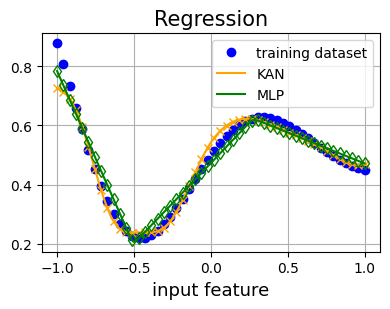

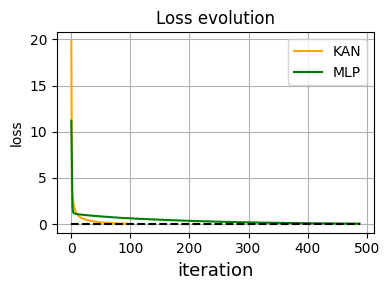

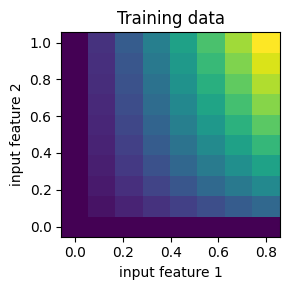

100%|██████████| 500/500 [00:05<00:00, 91.46it/s, loss: 0.349]


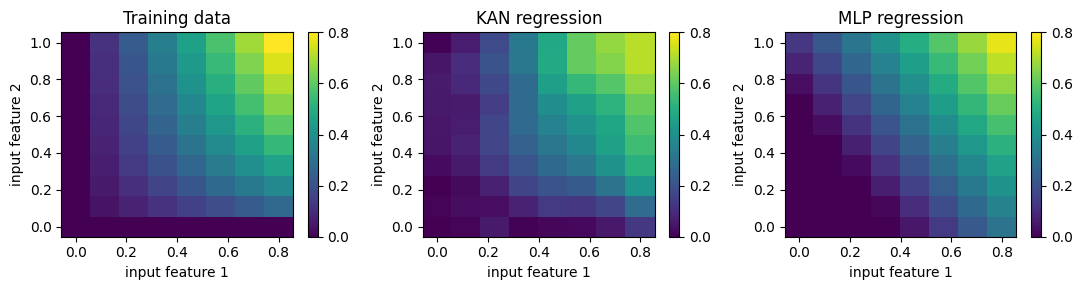

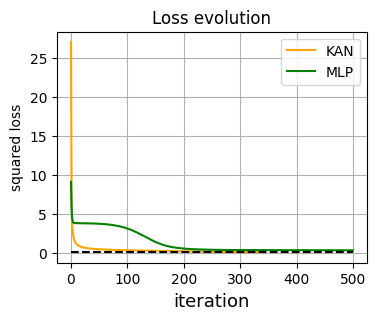

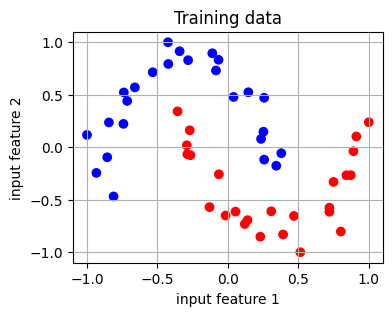

100%|██████████| 1000/1000 [00:18<00:00, 55.22it/s, loss: 6.421]


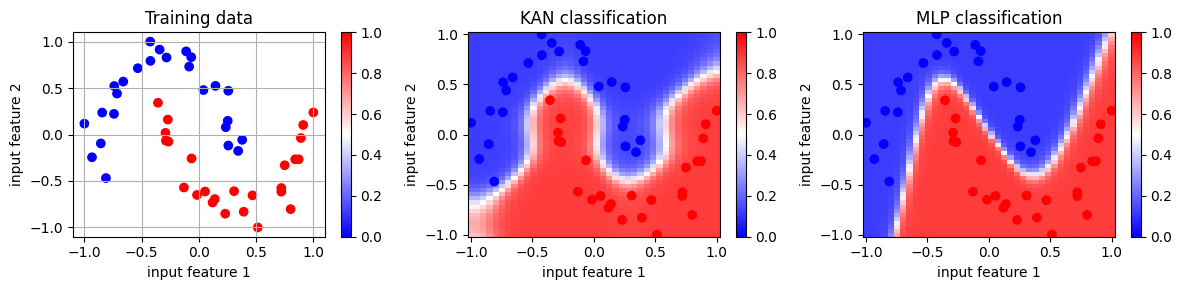

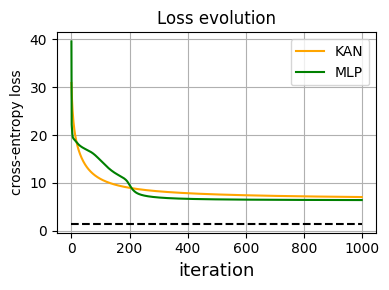

In [ ]:
%matplotlib inline
%pip install numpy matplotlib
import numpy as np
from feed_forward_network.feedforward import FeedForward
from neuron.neuron_nn import NeuronNN
from neuron.neuron_kan import NeuronKAN
import matplotlib.pyplot as plt
from utils.activations import tanh_act, relu, sigmoid_act
from utils.edge_fun import get_bsplines

folder_fig = './'

color_plots = {'dataset': 'b',
               'kan': 'orange',
               'mlp': 'green'}

n_iter_train_1d = 500
loss_tol_1d = .05
seed = 476

x_train = np.linspace(-1, 1, 50).reshape(-1, 1)
y_train = .5 * np.sin(4 * x_train) * np.exp(-(x_train+1)) + .5  # damped sinusoid

# KAN training
kan_1d = FeedForward([1, 2, 2, 1],  # layer size
                  eps=.01,  # gradient descent parameter
                  n_weights_per_edge=7,  # n. edge functions
                  neuron_class=NeuronKAN,
                  x_bounds=[-1, 1],  # input domain bounds
                  get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                  seed=seed,
                  weights_range=[-1, 1])
kan_1d.train(x_train,
          y_train,
          n_iter_max=n_iter_train_1d,
          loss_tol=loss_tol_1d)

# MLP training
mlp_1d = FeedForward([1, 13, 1],  # layer size
                  eps=.005,  # gradient descend parameter
                  activation=relu,  # activation type (ReLU, tanh or sigmoid)
                  neuron_class=NeuronNN,
                  seed=seed,
                  weights_range=[-.5, .5])
mlp_1d.train(x_train,
             y_train,
             n_iter_max=n_iter_train_1d,
             loss_tol=loss_tol_1d)

# Regression on training data
fig, ax = plt.subplots(figsize=(4,3.2))
x_plot = np.linspace(x_train[0], x_train[-1], 1000).reshape(-1, 1)
ax.plot(x_train, y_train, 'o', color=color_plots['dataset'], label='training dataset')
ax.plot(x_plot, [kan_1d(x) for x in x_plot], color=color_plots['kan'], label='KAN')
ax.plot(x_train, [kan_1d(x) for x in x_train], 'x', color=color_plots['kan'], fillstyle='none')
ax.plot(x_plot, [mlp_1d(x) for x in x_plot], color=color_plots['mlp'], label='MLP')
ax.plot(x_train, [mlp_1d(x) for x in x_train], 'd', color=color_plots['mlp'], fillstyle='none')
ax.set_xlabel('input feature', fontsize=13)
ax.set_title('Regression', fontsize=15)
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

fig1, ax1 = plt.subplots(figsize=(4,3))
ax1.plot(kan_1d.loss_hist, '-', color=color_plots['kan'], label='KAN')
ax1.plot(mlp_1d.loss_hist, '-', color=color_plots['mlp'], label='MLP')
ax1.plot(loss_tol_1d * np.ones(max(len(mlp_1d.loss_hist), len(kan_1d.loss_hist))), '--k')
ax1.grid()
ax1.set_ylabel('loss')
ax1.set_xlabel('iteration', fontsize=13)
ax1.legend()
ax1.set_title('Loss evolution')
fig1.tight_layout()
plt.show()

def fun2d(X1, X2):
    return X1 * np.power(X2, .5)

X1, X2 = np.meshgrid(np.linspace(0, .8, 8), np.linspace(0, 1, 10))
Y_training = fun2d(X1, X2)

x_train2d = np.concatenate((X1.reshape(-1, 1), X2.reshape(-1, 1)), axis=1)
y_train2d = Y_training.reshape(-1, 1)

f, a = plt.subplots(figsize=(3,3))
a.set_xlabel('input feature 1')
a.set_ylabel('input feature 2')
a.pcolor(X1, X2, Y_training)
a.set_title('Training data')
f.tight_layout()
plt.show()


n_iter_train_2d = 500
loss_tol_2d = .1
seed = 476

kan_2d = FeedForward([2, 2, 1],  # layer size
                  eps=.02,  # gradient descent parameter
                  n_weights_per_edge=10,  # n. edge functions
                  neuron_class=NeuronKAN,
                  x_bounds=[-1, 1],  # input domain bounds
                  get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                  seed=seed,
                  weights_range=[-1, 1])
kan_2d.train(x_train2d,
          y_train2d,
          n_iter_max=n_iter_train_2d,
          loss_tol=loss_tol_2d)


mlp_2d = FeedForward([2, 6, 1],  # layer size
                     eps=.0025,  # gradient descend parameter
                     activation=relu,  # activation type (ReLU, tanh or sigmoid)
                     neuron_class=NeuronNN,
                     seed=seed,
                     weights_range=[-.1, .1])
mlp_2d.train(x_train2d,
             y_train2d,
             n_iter_max=n_iter_train_2d,
             loss_tol=loss_tol_2d)

Y_kan = np.array([kan_2d(xx) for xx in x_train2d])
Y_mlp = np.array([mlp_2d(xx) for xx in x_train2d])

f, a = plt.subplots(1, 3, figsize=(11,3))

vmin, vmax = min(Y_training.flatten()), max(Y_training.flatten())

im0 = a[0].pcolor(X1, X2, Y_training, vmin=vmin, vmax=vmax)
f.colorbar(im0, ax=a[0])
a[0].set_title('Training data')
a[0].set_xlabel('input feature 1')
a[0].set_ylabel('input feature 2')

im1 = a[1].pcolor(X1, X2, Y_kan.reshape(X1.shape), vmin=vmin, vmax=vmax)
f.colorbar(im1, ax=a[1])
a[1].set_title('KAN regression')
a[1].set_xlabel('input feature 1')
a[1].set_ylabel('input feature 2')

im2 = a[2].pcolor(X1, X2, Y_mlp.reshape(X1.shape), vmin=vmin, vmax=vmax)
f.colorbar(im2, ax=a[2])
a[2].set_title('MLP regression')
a[2].set_xlabel('input feature 1')
a[2].set_ylabel('input feature 2')

f.tight_layout()
plt.show()

fig1, ax1 = plt.subplots(figsize=(4,3))
ax1.plot(kan_2d.loss_hist, '-', color=color_plots['kan'], label='KAN')
ax1.plot(mlp_2d.loss_hist, '-', color=color_plots['mlp'], label='MLP')
ax1.plot(loss_tol_2d * np.ones(max(len(mlp_2d.loss_hist), len(kan_2d.loss_hist))), '--k')
ax1.grid()
ax1.set_ylabel('squared loss')
ax1.set_xlabel('iteration', fontsize=13)
ax1.legend()
ax1.set_title('Loss evolution')
plt.show()


from sklearn import datasets

n_samples = 50
noise = 0.1
x_train_cl, y_train_cl = datasets.make_moons(n_samples=n_samples, noise=noise)
# normalize between -1 and 1
x_train_cl[:, 0] = (x_train_cl[:, 0] - min(x_train_cl[:, 0])) / max(x_train_cl[:, 0] - min(x_train_cl[:, 0])) * 2 - 1
x_train_cl[:, 1] = (x_train_cl[:, 1] - min(x_train_cl[:, 1])) / max(x_train_cl[:, 1] - min(x_train_cl[:, 1])) * 2 - 1

fig, ax = plt.subplots(figsize=(4,3))
ax.scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax.set_xlabel('input feature 1')
ax.set_ylabel('input feature 2')
ax.grid()
ax.set_title("Training data")
plt.show()

n_iter_train_cl = int(1e3)
loss_tol_cl = 1.5
seed = 476

from loss.cross_entropy_loss import CrossEntropyLoss

kan_cl = FeedForward([2, 2],  # layer size
                     eps=.02,  # gradient descent parameter
                     n_weights_per_edge=8,  # n. edge functions
                     neuron_class=NeuronKAN,
                     loss=CrossEntropyLoss,
                     x_bounds=[-1, 1],  # input domain bounds
                     get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                     seed=seed,
                     weights_range=[-1, 1])
kan_cl.train(x_train_cl,
             y_train_cl.reshape(-1, 1),
             n_iter_max=n_iter_train_cl,
             loss_tol=loss_tol_cl)

mlp_cl = FeedForward([2, 10, 10, 2],  # layer size
                     eps=.01,  # gradient descend parameter
                     activation=tanh_act,  # activation type (relu, tanh_act or sigmoid_act)
                     neuron_class=NeuronNN,
                     loss=CrossEntropyLoss,
                     seed=seed,
                     weights_range=[-1, 1])
mlp_cl.train(x_train_cl,
             y_train_cl.reshape(-1, 1),
             n_iter_max=n_iter_train_cl,
             loss_tol=loss_tol_cl)

def softmax(vec):
    return np.exp(vec) / sum(np.exp(vec))

X1_cl, X2_cl = np.meshgrid(np.linspace(-1, 1, 40), np.linspace(-1, 1, 50))
x_cl = np.concatenate((X1_cl.reshape(-1, 1), X2_cl.reshape(-1, 1)), axis=1)

Y_kan_cl = np.array([softmax(kan_cl(x))[1] for x in x_cl]).reshape(X1_cl.shape)
Y_mlp_cl = np.array([softmax(mlp_cl(x))[1] for x in x_cl]).reshape(X1_cl.shape)

fig_cl, ax_cl = plt.subplots(1, 3, figsize=(12,3))
# vmin, vmax = min(Y_training.flatten()), max(Y_training.flatten())

ax_cl[0].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[0].grid()
ax_cl[0].set_title('Training data')
ax_cl[0].set_xlabel('input feature 1')
ax_cl[0].set_ylabel('input feature 2')

im0 = ax_cl[1].pcolor(X1_cl, X2_cl, Y_kan_cl, vmin=0, vmax=1, cmap=plt.cm.bwr)
ax_cl[1].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[1].set_title('KAN classification')
ax_cl[1].set_xlabel('input feature 1')
ax_cl[1].set_ylabel('input feature 2')

im1 = ax_cl[2].pcolor(X1_cl, X2_cl, Y_mlp_cl, vmin=0, vmax=1, cmap=plt.cm.bwr)
ax_cl[2].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[2].set_title('MLP classification')
ax_cl[2].set_xlabel('input feature 1')
ax_cl[2].set_ylabel('input feature 2')

fig_cl.colorbar(im1, ax=ax_cl[0])
fig_cl.colorbar(im1, ax=ax_cl[1])
fig_cl.colorbar(im1, ax=ax_cl[2])
fig_cl.tight_layout()
plt.show()
# fig_cl.savefig(folder_fig + 'classification.png', dpi=500)

fig1, ax1 = plt.subplots(figsize=(4,3))
ax1.plot(kan_cl.loss_hist, '-', color=color_plots['kan'], label='KAN')
ax1.plot(mlp_cl.loss_hist, '-', color=color_plots['mlp'], label='MLP')
ax1.plot(loss_tol_cl * np.ones(max(len(mlp_cl.loss_hist), len(kan_cl.loss_hist))), '--k')
ax1.grid()
ax1.set_ylabel('cross-entropy loss')
ax1.set_xlabel('iteration', fontsize=13)
ax1.legend()
ax1.set_title('Loss evolution')
fig1.tight_layout()
plt.show()

In [ ]:
# Librerías necesarias
%matplotlib inline
%pip install numpy matplotlib tqdm

import numpy as np
import matplotlib.pyplot as plt
from feed_forward_network.feedforward import FeedForward
from neuron.neuron_nn import NeuronNN
from neuron.neuron_kan import NeuronKAN
from utils.activations import tanh_act, relu
from utils.edge_fun import get_bsplines

# Configuración para guardar figuras
folder_fig = './'
color_plots = {'dataset': 'b', 'kan': 'orange', 'mlp': 'green'}

# Parámetros de entrenamiento
n_iter_train_1d = 500
loss_tol_1d = 0.05
seed = 476


""" # Generación del dataset
x_train = np.linspace(-1, 1, 1000).reshape(-1, 1)  # 2000 puntos en [-1, 1]
y_train = 0.5 * np.sin(4 * x_train) * np.exp(-(x_train + 1)) + 0.5  # Seno amortiguado

 """

x_train = np.linspace(-1, 1, 100).reshape(-1, 1)  # 1000 puntos en [-1, 1]
y_train = 0.5 * np.cos(4 * x_train) * np.exp(-(x_train + 1)) + 0.5  # Coseno amortiguado


# Entrenamiento de la red KAN
kan_1d = FeedForward([1, 2, 2, 1],  # layer size
                  eps=.01,  # gradient descent parameter
                  n_weights_per_edge=7,  # n. edge functions
                  neuron_class=NeuronKAN,
                  x_bounds=[-1, 1],  # input domain bounds
                  get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                  seed=seed,
                  weights_range=[-1, 1])
kan_1d.train(x_train,
          y_train,
          n_iter_max=n_iter_train_1d,
          loss_tol=loss_tol_1d)

y_min, y_max = y_train.min(), y_train.max()
y_train_norm = (y_train - y_min) / (y_max - y_min)


# Entrenamiento de la red MLP
mlp_1d = FeedForward([1, 13, 1],  # layer size
                  eps=.005,  # gradient descend parameter
                  activation=relu,  # activation type (ReLU, tanh or sigmoid)
                  neuron_class=NeuronNN,
                  seed=seed,
                  weights_range=[-.5, .5])
mlp_1d.train(x_train,
             y_train,
             n_iter_max=n_iter_train_1d,
             loss_tol=loss_tol_1d)


fig, ax = plt.subplots(figsize=(4,3.2))
x_plot = np.linspace(x_train[0], x_train[-1], 1000).reshape(-1, 1)
ax.plot(x_train, y_train, 'o', color=color_plots['dataset'], label='training dataset')
ax.plot(x_plot, [kan_1d(x) for x in x_plot], color=color_plots['kan'], label='KAN')
ax.plot(x_train, [kan_1d(x) for x in x_train], 'x', color=color_plots['kan'], fillstyle='none')
ax.plot(x_plot, [mlp_1d(x) for x in x_plot], color=color_plots['mlp'], label='MLP')
ax.plot(x_train, [mlp_1d(x) for x in x_train], 'd', color=color_plots['mlp'], fillstyle='none')
ax.set_xlabel('input feature', fontsize=13)
ax.set_title('Regression', fontsize=15)
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()


fig1, ax1 = plt.subplots(figsize=(4,3))
ax1.plot(kan_1d.loss_hist, '-', color=color_plots['kan'], label='KAN')
ax1.plot(mlp_1d.loss_hist, '-', color=color_plots['mlp'], label='MLP')
ax1.plot(loss_tol_1d * np.ones(max(len(mlp_1d.loss_hist), len(kan_1d.loss_hist))), '--k')
ax1.grid()
ax1.set_ylabel('loss')
ax1.set_xlabel('iteration', fontsize=13)
ax1.legend()
ax1.set_title('Loss evolution')
fig1.tight_layout()
plt.show()

print('DATASET CON DOS DIMENSIONES')

def fun2d_new(X1, X2):
    return np.sin(X1) * np.cos(X2)

X1, X2 = np.meshgrid(np.linspace(0, 2 * np.pi, 8), np.linspace(0, 2 * np.pi, 10))
Y_training = fun2d_new(X1, X2)

x_train2d = np.concatenate((X1.reshape(-1, 1), X2.reshape(-1, 1)), axis=1)
y_train2d = Y_training.reshape(-1, 1)


from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train2d[:, 0], x_train2d[:, 1], y_train2d, color='blue')
ax.set_title("Nuevo dataset: sin(X1) * cos(X2)")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("Y")
plt.show()

n_iter_train_2d = 500
loss_tol_2d = .1
seed = 476

kan_2d = FeedForward([2, 2, 1],  # layer size
                  eps=.02,  # gradient descent parameter
                  n_weights_per_edge=10,  # n. edge functions
                  neuron_class=NeuronKAN,
                  x_bounds=[-1, 1],  # input domain bounds
                  get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                  seed=seed,
                  weights_range=[-1, 1])
kan_2d.train(x_train2d,
          y_train2d,
          n_iter_max=n_iter_train_2d,
          loss_tol=loss_tol_2d)


mlp_2d = FeedForward([2, 6, 1],  # layer size
                     eps=.0025,  # gradient descend parameter
                     activation=relu,  # activation type (ReLU, tanh or sigmoid)
                     neuron_class=NeuronNN,
                     seed=seed,
                     weights_range=[-.1, .1])
mlp_2d.train(x_train2d,
             y_train2d,
             n_iter_max=n_iter_train_2d,
             loss_tol=loss_tol_2d)


Y_kan = np.array([kan_2d(xx) for xx in x_train2d])
Y_mlp = np.array([mlp_2d(xx) for xx in x_train2d])

f, a = plt.subplots(1, 3, figsize=(11,3))

vmin, vmax = min(Y_training.flatten()), max(Y_training.flatten())

im0 = a[0].pcolor(X1, X2, Y_training, vmin=vmin, vmax=vmax)
f.colorbar(im0, ax=a[0])
a[0].set_title('Training data')
a[0].set_xlabel('input feature 1')
a[0].set_ylabel('input feature 2')

im1 = a[1].pcolor(X1, X2, Y_kan.reshape(X1.shape), vmin=vmin, vmax=vmax)
f.colorbar(im1, ax=a[1])
a[1].set_title('KAN regression')
a[1].set_xlabel('input feature 1')
a[1].set_ylabel('input feature 2')

im2 = a[2].pcolor(X1, X2, Y_mlp.reshape(X1.shape), vmin=vmin, vmax=vmax)
f.colorbar(im2, ax=a[2])
a[2].set_title('MLP regression')
a[2].set_xlabel('input feature 1')
a[2].set_ylabel('input feature 2')

f.tight_layout()
plt.show()


fig1, ax1 = plt.subplots(figsize=(4,3))
ax1.plot(kan_2d.loss_hist, '-', color=color_plots['kan'], label='KAN')
ax1.plot(mlp_2d.loss_hist, '-', color=color_plots['mlp'], label='MLP')
ax1.plot(loss_tol_2d * np.ones(max(len(mlp_2d.loss_hist), len(kan_2d.loss_hist))), '--k')
ax1.grid()
ax1.set_ylabel('squared loss')
ax1.set_xlabel('iteration', fontsize=13)
ax1.legend()
ax1.set_title('Loss evolution')
plt.show()




ModuleNotFoundError: No module named 'feed_forward_network'

Luego para implementar la clasificacion de los datos, se va a realizar con un nuevo dataset, donde se pueda representar de mejor forma la distribución de los puntos para poder realizar una clasificación de manera correcta. Posteriormente, se va a realizar una comparativa con los datasets utilizados en el tutorial.

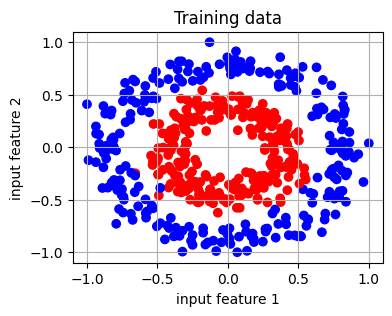

In [ ]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

n_samples = 500
noise = 0.1
x_train_cl, y_train_cl = datasets.make_circles(n_samples=n_samples, noise=noise, factor=0.5)
# normalizar entre -1 y 1
x_train_cl[:, 0] = (x_train_cl[:, 0] - min(x_train_cl[:, 0])) / max(x_train_cl[:, 0] - min(x_train_cl[:, 0])) * 2 - 1
x_train_cl[:, 1] = (x_train_cl[:, 1] - min(x_train_cl[:, 1])) / max(x_train_cl[:, 1] - min(x_train_cl[:, 1])) * 2 - 1

fig, ax = plt.subplots(figsize=(4,3))
ax.scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax.set_xlabel('input feature 1')
ax.set_ylabel('input feature 2')
ax.grid()
ax.set_title("Training data")
plt.show()

Como se puede observar, se va a utilizar el dataset de la función make_circles sacado de sklearn.datasets. Este crea el conjunto de datos mostrado en el gráfico. Así se va a realizar una clasificación de estos datos utilizando la arquitectura KAN.

100%|██████████| 1000/1000 [02:59<00:00,  5.57it/s, loss: 205.629]


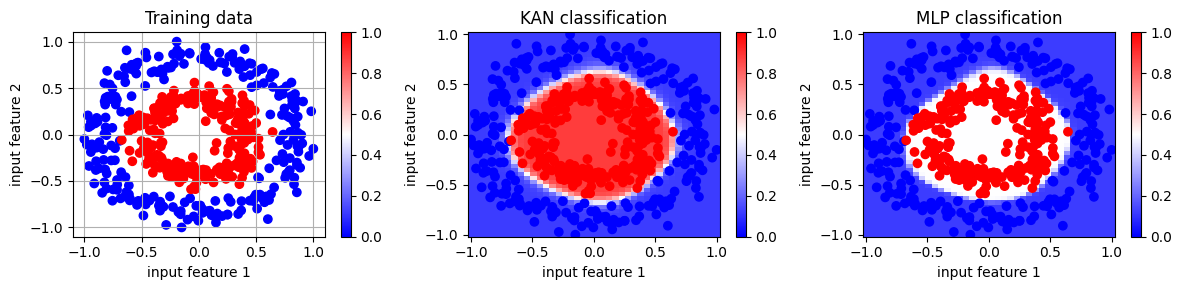

loss evolution:


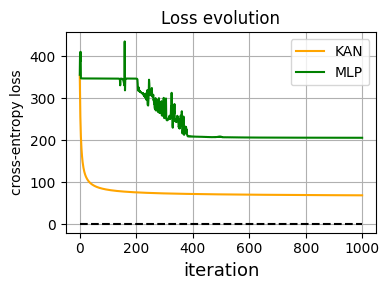

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from feed_forward_network.feedforward import FeedForward
from neuron.neuron_nn import NeuronNN
from neuron.neuron_kan import NeuronKAN
from utils.activations import tanh_act, relu
from utils.edge_fun import get_bsplines
from sklearn import datasets

n_samples = 500
noise = 0.1
x_train_cl, y_train_cl = datasets.make_circles(n_samples=n_samples, noise=noise, factor=0.5)
# normalize between -1 and 1
x_train_cl[:, 0] = (x_train_cl[:, 0] - min(x_train_cl[:, 0])) / max(x_train_cl[:, 0] - min(x_train_cl[:, 0])) * 2 - 1
x_train_cl[:, 1] = (x_train_cl[:, 1] - min(x_train_cl[:, 1])) / max(x_train_cl[:, 1] - min(x_train_cl[:, 1])) * 2 - 1


n_iter_train_cl = int(1e3)
loss_tol_cl = 1.5
seed = 476

from loss.cross_entropy_loss import CrossEntropyLoss

kan_cl = FeedForward([2, 2],  # layer size
                     eps=.02,  # gradient descent parameter
                     n_weights_per_edge=8,  # n. edge functions
                     neuron_class=NeuronKAN,
                     loss=CrossEntropyLoss,
                     x_bounds=[-1, 1],  # input domain bounds
                     get_edge_fun=get_bsplines,  # edge function type (B-splines ot Chebyshev)
                     seed=seed,
                     weights_range=[-1, 1])
kan_cl.train(x_train_cl,
             y_train_cl.reshape(-1, 1),
             n_iter_max=n_iter_train_cl,
             loss_tol=loss_tol_cl)

mlp_cl = FeedForward([2, 10, 10, 2],  # layer size
                     eps=.01,  # gradient descend parameter
                     activation=tanh_act,  # activation type (relu, tanh_act or sigmoid_act)
                     neuron_class=NeuronNN,
                     loss=CrossEntropyLoss,
                     seed=seed,
                     weights_range=[-1, 1])
mlp_cl.train(x_train_cl,
             y_train_cl.reshape(-1, 1),
             n_iter_max=n_iter_train_cl,
             loss_tol=loss_tol_cl)

def softmax(vec):
    return np.exp(vec) / sum(np.exp(vec))

X1_cl, X2_cl = np.meshgrid(np.linspace(-1, 1, 40), np.linspace(-1, 1, 50))
x_cl = np.concatenate((X1_cl.reshape(-1, 1), X2_cl.reshape(-1, 1)), axis=1)

Y_kan_cl = np.array([softmax(kan_cl(x))[1] for x in x_cl]).reshape(X1_cl.shape)
Y_mlp_cl = np.array([softmax(mlp_cl(x))[1] for x in x_cl]).reshape(X1_cl.shape)

fig_cl, ax_cl = plt.subplots(1, 3, figsize=(12,3))


ax_cl[0].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[0].grid()
ax_cl[0].set_title('Training data')
ax_cl[0].set_xlabel('input feature 1')
ax_cl[0].set_ylabel('input feature 2')

im0 = ax_cl[1].pcolor(X1_cl, X2_cl, Y_kan_cl, vmin=0, vmax=1, cmap=plt.cm.bwr)
ax_cl[1].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[1].set_title('KAN classification')
ax_cl[1].set_xlabel('input feature 1')
ax_cl[1].set_ylabel('input feature 2')

im1 = ax_cl[2].pcolor(X1_cl, X2_cl, Y_mlp_cl, vmin=0, vmax=1, cmap=plt.cm.bwr)
ax_cl[2].scatter(*x_train_cl.T, c=y_train_cl, cmap=plt.cm.bwr)
ax_cl[2].set_title('MLP classification')
ax_cl[2].set_xlabel('input feature 1')
ax_cl[2].set_ylabel('input feature 2')

fig_cl.colorbar(im1, ax=ax_cl[0])
fig_cl.colorbar(im1, ax=ax_cl[1])
fig_cl.colorbar(im1, ax=ax_cl[2])
fig_cl.tight_layout()
plt.show()

print('loss evolution:')

fig1, ax1 = plt.subplots(figsize=(4,3))
ax1.plot(kan_cl.loss_hist, '-', color=color_plots['kan'], label='KAN')
ax1.plot(mlp_cl.loss_hist, '-', color=color_plots['mlp'], label='MLP')
ax1.plot(loss_tol_cl * np.ones(max(len(mlp_cl.loss_hist), len(kan_cl.loss_hist))), '--k')
ax1.grid()
ax1.set_ylabel('cross-entropy loss')
ax1.set_xlabel('iteration', fontsize=13)
ax1.legend()
ax1.set_title('Loss evolution')
fig1.tight_layout()
plt.show()

# Pregunta 2:

A continuación se procede a implementar un dataset propio, el cual va a corresponder a una generación de 2000 datos aleatorios siguiendo una curva de seno amortiguado para la correcta implementación del algoritmo de aprendizaje. Se van a comprar las gráficas obtenidas por el loss progresivo y también por la curva de aprendizaje de cada dataset nuevo incluido.

Luego si se quiere implementar para un conjunto de datos en 2D, se va a utilizar una función para generar los datos correspondientes sin(X1) * cos(X2). De esta forma se tendran dos dimensiones para representar los datos, y realizar una regresion con el algoritmo KAN.

En el algoritmo KAN, la separación de las clases en el gráfico de clasificación es clara y parece ajustarse bien a los datos. No se observa una sobre-representación de patrones específicos o ruido, y la frontera de decisión es suave y bien definida. La pérdida converge rápidamente a un valor bajo, lo que indica que el modelo aprende eficientemente. No hay evidencia de oscilaciones o aumento de la pérdida, que son signos comunes de overfitting.

El modelo MLP no logra una buena separación entre las clases. Su desempeño en los datos de entrenamiento no es ideal, lo que indica que ni siquiera ha aprendido correctamente los patrones presentes en estos datos. Este comportamiento no se alinea con el overfitting, que normalmente implica un ajuste excesivo a los datos de entrenamiento. Además, la pérdida del MLP se estabiliza en un valor relativamente alto y no converge adecuadamente. Esto sugiere underfitting, no overfitting, ya que el modelo no es capaz de aprender correctamente los patrones de los datos.

# PREGUNTA 3:

